In [450]:
from __future__ import division  
import pandas as pd
import math
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold 
import xgboost as xgb  
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

## data processing

In [121]:
Features = pd.read_csv('./dataset/TrainFeatures.csv')
Labels = pd.read_csv('./dataset/TrainLabel.csv')
video_info = pd.read_csv('./dataset/VideoInfo.csv')
features_test = pd.read_csv('./dataset/TestFeatures.csv')

In [127]:
def Eventype2EventColumn(features, label = None):

    Event_type = list(set(features['event_type']))
    User_id = list(set(features['user_id']))
    
    user_event = features.groupby(['user_id', 'event_type']).count()
    
    user_event_count = user_event.reset_index().iloc[:, 0:3]
    user_event_df = pd.DataFrame(np.zeros([len(User_id), len(Event_type)]), index = User_id, columns = Event_type)
 #   print len(user_event_df)
    for user in User_id:
        for event in Event_type:
            if event in list(user_event_count[user_event_count.user_id == user].event_type):
                user_event_df.loc[user][event] = user_event_count[user_event_count.user_id == user][user_event_count.event_type == event].video_id
            else:
                user_event_df.loc[user][event] = 0
    user_event_df = user_event_df.reset_index()
    
    if label is None:
        output = user_event_df
    else:
        output = user_event_df.merge(label, left_on='index', right_on='user_id')
    
    return output

In [211]:
#add video number as the feature
def Eventype2ColumnWithVideo(features, label = None):
    
    Event_type = list(set(features['event_type']))
    User_id = list(set(features['user_id']))
    
    #Count the the number of each event type for each user
    user_event = features.groupby(['user_id', 'event_type']).count()
    #Count how many videos 
    user_video = features.groupby(['user_id']).agg({'video_id':lambda x:np.unique(x).shape[0]}).reset_index()

    user_event_count = user_event.reset_index().iloc[:, 0:3]
    user_event_df = pd.DataFrame(np.zeros([len(User_id), len(Event_type)]), index = User_id, columns = Event_type)

    for user in User_id:
        for event in Event_type:
            if event in list(user_event_count[user_event_count.user_id == user].event_type):
                user_event_df.loc[user][event] = user_event_count[user_event_count.user_id == user][user_event_count.event_type == event].video_id
            else:
                user_event_df.loc[user][event] = 0
    user_event_df = user_event_df.reset_index()
    
    user_event_video = user_event_df.merge(user_video, left_on='index', right_on='user_id')  
    user_event_video.pop('user_id')



    
    if label is None:
        output = user_event_video
    else:
        output = user_event_video.merge(label, left_on='index', right_on='user_id')
    
    return output

In [134]:
%%time
Train_user_event = Eventype2EventColumn(features, labels)
Test_user_event = Eventype2EventColumn(features_test)

5050


/Users/milan/Desktop/My_python/my_project/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


1293
CPU times: user 7min 47s, sys: 4.04 s, total: 7min 51s
Wall time: 11min 2s


In [212]:
%%time
Train_user_event_video = Eventype2ColumnWithVideo(Features, Labels)
Test_user_event_video = Eventype2ColumnWithVideo(features_test)

/Users/milan/Desktop/My_python/my_project/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


CPU times: user 4min 15s, sys: 1.14 s, total: 4min 16s
Wall time: 4min 17s


- Feature generation

In [581]:
# For the train data
# Merge the feature and article info into one table
Feature_video = Features.merge(video_info)

# Calculate the sum of duration grouped by session
user_session_duration = Feature_video.groupby(['user_id','session'])['duration'].sum()
user_session_duration = user_session_duration.reset_index()

# Calculate the average sesson duraiton grouped by user_id
user_SessionDuration = user_session_duration.groupby('user_id')['duration'].mean()
user_SessionDuration = user_SessionDuration.reset_index()
Train_user_event_video_SessionDuration = user_SessionDuration.merge(Train_user_event_video, left_on= 'user_id', right_on='index')
Train_user_event_video_SessionDuration.pop('index')

0       0005266eb37020aaa9d87eccc6d051b3
1       00283999ebb74c7052f962400b51af1b
2       003cb7ee2f970b407b0087075b41b608
3       004cab314f7310363f7a802369867f9e
4       006c65a0946666507fd85ad824ff5909
5       0083870f576cd563ee5b19c97ef77a2c
6       00a7076382b9970980e540230e0bf61f
7       00ab1656a2996a97029c3fa7a7010498
8       00afe3e30d052142dc018ef0e9ca7b30
9       00c8744837dba943b3f1e8bad3791ab4
10      00dfc0d6d770e90756b197e15fbd25ec
11      00e757623c2382f0586b288d6cf76f7b
12      00f6c7661b7e1e8c95abd2c87784f655
13      00fdd7d3317a68e25c92a594095fff3e
14      0103a6b803a6f8f038b02f2d266e8782
15      0104411bee20fcbd6e67a3f00ca1b71d
16      0108949af4e36933a9f1ed024618ff07
17      0115d7d43aeafc0b56f7e5d05bc08aa8
18      013212ec5b9431829dedc44d2300748f
19      0136cb8515c3309f04f79131c5cd1d92
20      013cd591e30b6cd7915683f28f0e13aa
21      013ee0cbdb6d463a565e18a87972d689
22      0141fef25ed855ec48394b54b38a4228
23      014dd064e97dfb912e6534629c659b75
24      015d67c2

In [583]:
# For the test data
# Merge the feature and article info into one table
Feature_video_test = features_test.merge(video_info)

# Calculate the sum of duration grouped by session
user_session_duration_test = Feature_video_test.groupby(['user_id','session'])['duration'].sum()
user_session_duration_test = user_session_duration_test.reset_index()

# Calculate the average sesson duraiton grouped by user_id
user_SessionDuration_test = user_session_duration_test.groupby('user_id')['duration'].mean()
user_SessionDuration_test = user_SessionDuration_test.reset_index()

# To slove the error: TypeError: type object argument after * must be a sequence, not generator
Test_user_event_video['index'] = Test_user_event_video['index'].apply(bytes)
user_SessionDuration_test['user_id'] = user_SessionDuration_test['user_id'].apply(bytes)

Test_user_event_video_SessionDuration = user_SessionDuration_test.merge(Test_user_event_video, left_on= 'user_id', right_on='index', how = 'outer')
Test_user_event_video_SessionDuration.pop('index')

0       00069663a97a439538d04d3a7cd659a1
1       004fbc40e3999cb7575fce07a1fc8b7a
2       00936d9181fad38deec90d2af5baf0a0
3       00a98ff25199a9bab6cb5954be4f6d27
4       00b59133ff74f750038ac45cc8ab190d
5       00bdfdc3a749cb55e90f0c83ac90d167
6       013278f30aedb03506b64363183fd4bb
7       0181dbcc3606f670bbe50f984967f358
8       01a14d039a010c3c0db13efe0ba578bb
9       0227db897952e0792f6569b82d0b221b
10      0278371473fc78507dd572c7673d8f56
11      0286e056e2a4c074b7cb4312b8c2a368
12      028f5d6790ac5657af475ebe01a56079
13      02a46e617b989ae1da4de2876d5676f0
14      02ce9f5db5d92069dd39df43a10faa4f
15      02d016ff489b444e918a67d2fb4ccc10
16      02e395caaa76c1b26158f18fc8343f38
17      0305ebfffa18c5dd2bba6c7c4b5f8a86
18      0328ebe83847d5fcae81bc55fa477c6a
19      03290f49f5780f5141cdbd507bf26357
20      03ce0f922f9ce7877e57bcdccbc9c8b4
21      0425ec756d3d6746c5a4c2305d56166d
22      0493d4b78d9aaf82a87ac0838a4c03d9
23      049959a885168c0c9ee3efbb6919c4a2
24      04c85312

## Find out outliers 

In [611]:
def CleanOutliers(data,feature_num, n_neig, cont):
    # Filter the column to calculate the outlier 
    X = data[data.grade == 0].iloc[:, 1:(1 + feature_num)]
    # Define the parameter of outlier classifier 
    clf = LocalOutlierFactor(n_neighbors = n_neig, contamination = cont)
    y_pred = clf.fit_predict(X)
    y_pred_outliers_index = [index for index in range(len(y_pred)) if y_pred[index] == -1]
    
    #drop the outlier index
    data_cleaned = data.drop(data.index[y_pred_outliers_index])
    
#     print '-------------------The outlier number is %s ------------------'%len(y_pred_outliers_index)
    
    return data_cleaned

##  Baseline: KNN 

In [503]:
def CorrectRate(result, label):
    error = 0
    loss = 0
    for i in range(len(result)):
        if result[i] == label[i]:
            error += 0
        else:
            if label[i] == 1:
                loss += 1
            error += 1
#    print loss
    return (1 - error / len(result))

In [666]:
def cross_validation(data, labels, fold):#input should be list or array
    
    kf = KFold(n_splits = fold)
    CR = 0
    for train_idx, val_idx in kf.split(data):
        
        #with input is array
        train_data = data[train_idx]
        train_label = labels[train_idx]
        test_data = data[val_idx]
        test_label = labels[val_idx]
        
        
        neighbor = KNeighborsClassifier(n_neighbors = 5)
        #train process
        
        neighbor.fit(train_data, train_label)
        test_result = neighbor.predict(test_data)


        test_grade = list(test_label)
        CR += CorrectRate(test_result, test_grade)

        
#         print '---------------------Cross Validation------------------'
#         print 'Test result average: ',sum(test_result) / len(test_result)
#         print 'Test label average: ',sum(test_grade) / len(test_grade)
        
#     print CR / 5
    return CR / 5

- Train KNN

In [667]:
cross_validation(np.array(Train_user_event_video_clean.iloc[:, 1:8]),np.array(Train_user_event_video_clean.grade), 5)
# cross_validation(np.array(Train_user_event_video.iloc[:, 1:8]),np.array(Train_user_event_video.grade), 5)
# cross_validation(np.array(Train_video_event.iloc[:, 1:8]),np.array(Train_video_event.grade), 5)

0.8332673267326733

>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.02 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.04 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.06 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.08 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.1 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.12 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.14 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.16 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.18 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.2 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.22 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.24 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.26 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.28 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.3 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.32 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.34 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.36 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.38 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.4 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.

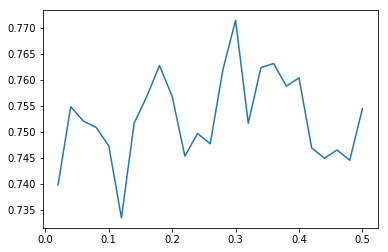

In [612]:
# Find out the most suitable number of outliers
Accurancy = []

Cont_range = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5]

for cont in Cont_range:
    print '>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = %s '%cont
    
    Train_user_event_video_SessionDuration_clean = CleanOutliers(Train_user_event_video_SessionDuration, 8, 20, cont)
    cross_validation(np.array(Train_user_event_video_SessionDuration_clean.iloc[:, 1:8]),np.array(Train_user_event_video_SessionDuration_clean.grade), 5)


    accurancy = cross_validation(np.array(Train_user_event_video_clean.iloc[:, 1:8]),np.array(Train_user_event_video_SessionDuration_clean.grade), 5)
    Accurancy.append(accurancy)

plt.plot(Cont_range, Accurancy)
plt.show()

- Test in KNN

In [619]:
neighbor = KNeighborsClassifier(n_neighbors = 5)
#train process
Train_user_event_video_SessionDuration_clean = CleanOutliers(Train_user_event_video_SessionDuration, 8, 10, 0.02)
neighbor.fit(Train_user_event_video_SessionDuration_clean.iloc[:, 1:9], Train_user_event_video_SessionDuration_clean.grade)
test_result = neighbor.predict(Test_user_event_video_SessionDuration.iloc[:,1:9])

print sum(test_result) / len(test_result)

0.092034029389


## XGBoost

In [672]:
def xgboost(train_data, train_label, test_data, test_label = None):
    
    dtrain = xgb.DMatrix(train_data, label = train_label)
    if test_label is None:
        dtest = xgb.DMatrix(test_data)
        # specify validations set to watch performance 
        watchlist  = [(dtrain,'train')] 
    else:
        dtest = xgb.DMatrix(test_data, label = test_label)
        labels = dtest.get_label()
        watchlist  = [(dtest,'eval'), (dtrain,'train')] 
        
    # Use map to define the parameter 
    param = {'max_depth':15, 'eta':0.2, 'silent':0, 'objective':'binary:logistic','min_child_weight':3,'gamma':15 }       
    # watchlist  = [(dtrain,'train')]  
    num_round = 30
    
#     bst = xgb.train(param, dtrain, num_round, watchlist)  
    bst = xgb.train(param, dtrain, num_round)  

    # this is prediction  
    preds = bst.predict(dtest)  
    preds = [int(preds[i]>0.5) for i in range(len(preds))]
   
    if test_label is None:
        return preds    
    else:
         #calculate the TP, TN, FP, FN
        TP = len([[preds[i]] for i in range(len(preds)) if preds[i]>0.5 and int(preds[i]>0.5)==labels[i]])
        FP = len([[preds[i]] for i in range(len(preds)) if preds[i]>0.5 and int(preds[i]>0.5)!=labels[i]])
        TN = len([[preds[i]] for i in range(len(preds)) if preds[i]<=0.5 and int(preds[i]>0.5)==labels[i]])
        FN = len([[preds[i]] for i in range(len(preds)) if preds[i]<=0.5 and int(preds[i]>0.5)!=labels[i]])
        
        return ((FP + FN) / len(preds)), ((TP + TN) / len(preds)), (TP / (TP + FP)), (TP / (TP + FN))
            

>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.02 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.04 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.06 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.08 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.1 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.12 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.14 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.16 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.18 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.2 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.22 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.24 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.26 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.28 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.3 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.32 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.34 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.36 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.38 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.4 
>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = 0.

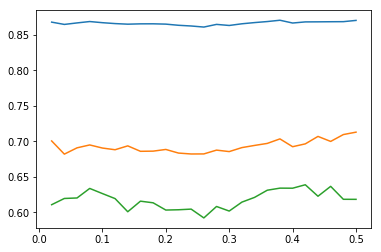

In [673]:
# Find out the most suitable number of outliers
Error = []
Accurancy = []
Precision = []
Recall = []

kf = KFold(n_splits = 5)

# Cont_range = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26]
# Cont_range = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16]
# Cont_range = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38]


Cont_range = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5]


for cont in Cont_range:
    
    error, accurancy, precison, recall = 0, 0, 0, 0
    
    print '>>>>>>>>>>>>>>>>>>>>>>>>>>contamination = %s '%cont
     
    Train_user_event_video_SessionDuration_clean = CleanOutliers(Train_user_event_video_SessionDuration, 8, 20, cont)
    data = np.array(Train_user_event_video_SessionDuration_clean.iloc[:, 1:9])
    label = np.array(Train_user_event_video_SessionDuration_clean.grade)

#     Train_video_event_clean = CleanOutliers(Train_video_event, 7, 20, cont)
#     data = np.array(Train_video_event_clean.iloc[:, 1:8])
#     label = np.array(Train_video_event_clean.grade)
    
    for train_idx, val_idx in kf.split(data):
        
        train_data = data[train_idx]
        train_label = label[train_idx]
        test_data = data[val_idx]
        test_label = label[val_idx]
        
        e, a, p, r = xgboost(train_data, train_label, test_data, test_label)
        
        error += e
        accurancy += a
        precison +=p
        recall += r
    
    Error.append(error / 5)
    Accurancy.append(accurancy / 5)
    Precision.append(precison / 5)
    Recall.append(recall / 5)

#     print 'error=%f' % error
#     print 'Accurancy=%f' % accurancy 
#     print 'Precision=%f' % precison
#     print 'Recall=%f' % recall

plt.plot(Cont_range, Accurancy, Cont_range, Precision, Cont_range, Recall)
plt.show()

   
#     del Train_user_event_video_SessionDuration_clean

In [674]:
# Test on the whole dataset
data_original = np.array(Train_user_event_video_SessionDuration.iloc[:, 1:9])
label_original = np.array(Train_user_event_video_SessionDuration.grade)

# data_original = np.array(Train_video_event.iloc[:, 1:8])
# label_original = np.array(Train_video_event.grade)

e, a, p, r = xgboost(train_data, train_label, data_original, label_original)
print 'error=%f' % e
print 'Accurancy=%f' % a 
print 'Precision=%f' % p
print 'Recall=%f' % r


error=0.125743
Accurancy=0.874257
Precision=0.709052
Recall=0.643206


In [675]:
# Predict the label of test user
train_data = np.array(Train_user_event_video_SessionDuration_clean.iloc[:, 1:9])
train_label = np.array(Train_user_event_video_SessionDuration_clean.grade)
test_data = np.array(Test_user_event_video_SessionDuration.iloc[:, 1:9])

preds_final = xgboost(train_data, train_label, test_data)


#Output the prediction to csv
result = pd.DataFrame(np.array(Test_user_event_video_SessionDuration.iloc[:,0]), columns = ['user_id'])
result['grade'] = preds_final

result.to_csv('result.csv')